# **Applying Vision Transformer (ViT)**
In our project, we incorporate the Vision Transformer (ViT) model to evaluate its performance in image classification tasks. The Vision Transformer is a model introduced by Google that adapts transformer architectures, originally designed for natural language processing, to the domain of computer vision.

**Model Overview:**

Architecture: The Vision Transformer (ViT) processes images by dividing them into fixed-size patches, which are then linearly embedded into a sequence of tokens. These tokens are fed into a transformer model to capture global context and relationships between different parts of the image.
Implementation: We use the ViTForImageClassification class from the transformers library, which provides a pre-trained Vision Transformer model specifically for image classification tasks. This allows us to leverage pre-trained weights and fine-tune the model on our specific dataset.

**Steps for Application:**

- **Data Preparation:** We preprocess the images by resizing them to the appropriate dimensions and normalizing pixel values. The ViTFeatureExtractor from the transformers library is used to apply these transformations.

- **Model Initialization:** We load the Vision Transformer model using ViTForImageClassification. This model is initialized with pre-trained weights that can be fine-tuned for our dataset.

- **Training:** The model is trained using our dataset, optimizing for classification accuracy. We employ standard training procedures including defining loss functions, optimizers, and learning rate schedulers.

- **Evaluation:** After training, we evaluate the model's performance on the test dataset to assess its classification accuracy and other relevant metrics such as precision, recall, and F1 score.

By integrating the Vision Transformer into our project, we aim to explore its effectiveness in image classification tasks and compare its performance with traditional convolutional neural network architectures.



In [ ]:
!pip install transformers
!pip install fuzzywuzzy
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
import os
import random
import shutil
import warnings
import tarfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from fuzzywuzzy import process
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.models import resnet18

from transformers import ViTForImageClassification, ViTFeatureExtractor
import timm

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    precision_recall_fscore_support, classification_report, confusion_matrix
)

from google.colab import drive

warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/CUB_200_2011.tgz'
if file_path.endswith("tgz"):
    tar = tarfile.open(file_path, "r:gz")
    tar.extractall()
    tar.close()

extracted_folder_path = 'CUB_200_2011'
image_folder_path = os.path.join(extracted_folder_path, 'images')


images_txt_path = os.path.join(extracted_folder_path, 'images.txt')
labels_txt_path = os.path.join(extracted_folder_path, 'image_class_labels.txt')
class_names_path = os.path.join(extracted_folder_path, 'classes.txt')

images_df = pd.read_csv(images_txt_path, sep=' ', header=None, names=['image_id', 'file_path'])
labels_df = pd.read_csv(labels_txt_path, sep=' ', header=None, names=['image_id', 'class_id'])
class_names_df = pd.read_csv(class_names_path, sep=' ', header=None, names=['class_id', 'class_name'])

data_df = pd.merge(images_df, labels_df, on='image_id')
data_df = pd.merge(data_df, class_names_df, on='class_id')

data_df['file_path'] = data_df['file_path'].apply(lambda x: os.path.join(image_folder_path, x))
data_df

Mounted at /content/drive


,image_id,file_path,class_id,class_name
0,1,CUB_200_2011/images/001.Black_footed_Albatross...,1,001.Black_footed_Albatross
1,2,CUB_200_2011/images/001.Black_footed_Albatross...,1,001.Black_footed_Albatross
2,3,CUB_200_2011/images/001.Black_footed_Albatross...,1,001.Black_footed_Albatross
3,4,CUB_200_2011/images/001.Black_footed_Albatross...,1,001.Black_footed_Albatross
4,5,CUB_200_2011/images/001.Black_footed_Albatross...,1,001.Black_footed_Albatross
...,...,...,...,...
11783,11784,CUB_200_2011/images/200.Common_Yellowthroat/Co...,200,200.Common_Yellowthroat
11784,11785,CUB_200_2011/images/200.Common_Yellowthroat/Co...,200,200.Common_Yellowthroat
11785,11786,CUB_200_2011/images/200.Common_Yellowthroat/Co...,200,200.Common_Yellowthroat
11786,11787,CUB_200_2011/images/200.Common_Yellowthroat/Co...,200,200.Common_Yellowthroat


In [ ]:
desired_categories = [7, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 28, 32, 35, 36, 42, 44,
                      45, 47, 48, 54, 55, 57, 59, 63, 67, 68, 72, 75, 76, 77, 78, 79, 85, 87,
                      89, 91, 93, 95, 99, 104, 108, 109, 111, 114, 116, 118, 134, 136, 138,
                      139, 143, 149, 158, 163, 164, 186, 191, 192, 194]
train_data = data_df[data_df['class_id'].isin(desired_categories)]

import re
def clean_class_name(class_name):
    cleaned_name = re.sub(r'^\d+\.', '', class_name).strip()
    return cleaned_name
train_data['class_name'] = train_data['class_name'].apply(clean_class_name)
class_id_mapping = {original_id: new_id for new_id, original_id in enumerate(desired_categories)}
train_data['class_id'] = train_data['class_id'].map(class_id_mapping)
train_data = train_data.drop(columns=['image_id'])
train_data = train_data[['class_id', 'file_path', 'class_name']]
train_data

,class_id,file_path,class_name
323,0,CUB_200_2011/images/007.Parakeet_Auklet/Parake...,Parakeet_Auklet
324,0,CUB_200_2011/images/007.Parakeet_Auklet/Parake...,Parakeet_Auklet
325,0,CUB_200_2011/images/007.Parakeet_Auklet/Parake...,Parakeet_Auklet
326,0,CUB_200_2011/images/007.Parakeet_Auklet/Parake...,Parakeet_Auklet
327,0,CUB_200_2011/images/007.Parakeet_Auklet/Parake...,Parakeet_Auklet
...,...,...,...
11424,62,CUB_200_2011/images/194.Cactus_Wren/Cactus_Wre...,Cactus_Wren
11425,62,CUB_200_2011/images/194.Cactus_Wren/Cactus_Wre...,Cactus_Wren
11426,62,CUB_200_2011/images/194.Cactus_Wren/Cactus_Wre...,Cactus_Wren
11427,62,CUB_200_2011/images/194.Cactus_Wren/Cactus_Wre...,Cactus_Wren


In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

class MultiClassDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe++++++
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        image = Image.open(img_path).convert("RGB")
        label = self.dataframe.iloc[idx]['class_id']
        if self.transform:
            image = self.transform(image)
        return image, label

dataset = MultiClassDataset(dataframe=train_data, transform=transform)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(desired_categories))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)  # Adjust lr and momentum as needed
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_epochs = 50
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []


best_val_loss = float('inf')
patience = 5
count = 0


for epoch in range(num_epochs):
    total_train_loss = 0
    total_val_loss = 0
    total_train = 0
    correct_train = 0
    model.train()


    for itr, (image, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        outputs = model(image).logits
        loss = criterion(outputs, label)
        total_train_loss += loss.item()

        predicted = torch.argmax(outputs, 1)
        total_train += label.size(0)
        correct_train += (predicted == label).sum().item()

        loss.backward()
        optimizer.step()

    accuracy_train = (100 * correct_train) / total_train
    train_accuracy.append(accuracy_train)
    total_train_loss /= len(train_loader)
    train_loss.append(total_train_loss)


    model.eval()
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for itr, (image, label) in enumerate(val_loader):
            image, label = image.to(device), label.to(device)

            outputs = model(image).logits
            loss = criterion(outputs, label)
            total_val_loss += loss.item()

            predicted = torch.argmax(outputs, dim=1)
            total_val += label.size(0)
            correct_val += (predicted == label).sum().item()

    accuracy_val = (100 * correct_val) / total_val
    val_accuracy.append(accuracy_val)
    total_val_loss /= len(val_loader)
    val_loss.append(total_val_loss)

    print(f'\nEpoch: {epoch + 1}/{num_epochs}, Train Loss: {total_train_loss:.8f}, '
          f'Train Accuracy: {accuracy_train:.8f}, Val Loss: {total_val_loss:.8f}, '
          f'Val Accuracy: {accuracy_val:.8f}')


    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        count = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        count += 1
        if count >= patience:
            print("Early stopping triggered.")
            break

100%|██████████| 94/94 [01:33<00:00,  1.01it/s]



Epoch: 1/50, Train Loss: 3.11654739, Train Accuracy: 70.46979866, Val Loss: 1.42283749, Val Accuracy: 92.48322148


100%|██████████| 94/94 [01:35<00:00,  1.02s/it]



Epoch: 2/50, Train Loss: 0.49756989, Train Accuracy: 96.54362416, Val Loss: 0.25981730, Val Accuracy: 96.10738255


100%|██████████| 94/94 [01:35<00:00,  1.02s/it]



Epoch: 3/50, Train Loss: 0.11339263, Train Accuracy: 98.42281879, Val Loss: 0.17714937, Val Accuracy: 97.71812081


100%|██████████| 94/94 [01:35<00:00,  1.02s/it]



Epoch: 4/50, Train Loss: 0.05539939, Train Accuracy: 99.46308725, Val Loss: 0.16385522, Val Accuracy: 97.71812081


100%|██████████| 94/94 [01:35<00:00,  1.02s/it]



Epoch: 5/50, Train Loss: 0.03268383, Train Accuracy: 99.79865772, Val Loss: 0.15896531, Val Accuracy: 97.31543624


100%|██████████| 94/94 [01:35<00:00,  1.02s/it]



Epoch: 6/50, Train Loss: 0.02106885, Train Accuracy: 99.89932886, Val Loss: 0.15851182, Val Accuracy: 97.58389262


100%|██████████| 94/94 [01:35<00:00,  1.02s/it]



Epoch: 7/50, Train Loss: 0.01375873, Train Accuracy: 99.96644295, Val Loss: 0.14843365, Val Accuracy: 97.31543624


100%|██████████| 94/94 [01:35<00:00,  1.02s/it]



Epoch: 8/50, Train Loss: 0.01083844, Train Accuracy: 99.96644295, Val Loss: 0.14781609, Val Accuracy: 97.44966443


100%|██████████| 94/94 [01:35<00:00,  1.02s/it]



Epoch: 9/50, Train Loss: 0.00849546, Train Accuracy: 100.00000000, Val Loss: 0.14508406, Val Accuracy: 97.44966443


100%|██████████| 94/94 [01:35<00:00,  1.02s/it]



Epoch: 10/50, Train Loss: 0.00723834, Train Accuracy: 100.00000000, Val Loss: 0.14503664, Val Accuracy: 97.44966443


100%|██████████| 94/94 [01:35<00:00,  1.02s/it]



Epoch: 11/50, Train Loss: 0.00635378, Train Accuracy: 100.00000000, Val Loss: 0.14624107, Val Accuracy: 97.44966443


100%|██████████| 94/94 [01:35<00:00,  1.02s/it]



Epoch: 12/50, Train Loss: 0.00567460, Train Accuracy: 100.00000000, Val Loss: 0.14652454, Val Accuracy: 97.44966443


100%|██████████| 94/94 [01:35<00:00,  1.02s/it]



Epoch: 13/50, Train Loss: 0.00511892, Train Accuracy: 100.00000000, Val Loss: 0.14653046, Val Accuracy: 97.58389262


100%|██████████| 94/94 [01:35<00:00,  1.02s/it]



Epoch: 14/50, Train Loss: 0.00467283, Train Accuracy: 100.00000000, Val Loss: 0.14689251, Val Accuracy: 97.58389262


100%|██████████| 94/94 [01:35<00:00,  1.02s/it]



Epoch: 15/50, Train Loss: 0.00430266, Train Accuracy: 100.00000000, Val Loss: 0.14743333, Val Accuracy: 97.58389262
Early stopping triggered.


In [ ]:
results_df = pd.DataFrame({
    'Epoch': range(1, len(train_loss) + 1),
    'Train Loss': train_loss,
    'Val Loss': val_loss,
    'Train Accuracy': train_accuracy,
    'Val Accuracy': val_accuracy
})
results_df

,Epoch,Train Loss,Val Loss,Train Accuracy,Val Accuracy
0,1,3.116547,1.422837,70.469799,92.483221
1,2,0.497570,0.259817,96.543624,96.107383
2,3,0.113393,0.177149,98.422819,97.718121
3,4,0.055399,0.163855,99.463087,97.718121
4,5,0.032684,0.158965,99.798658,97.315436
5,6,0.021069,0.158512,99.899329,97.583893
6,7,0.013759,0.148434,99.966443,97.315436
7,8,0.010838,0.147816,99.966443,97.449664
8,9,0.008495,0.145084,100.000000,97.449664
9,10,0.007238,0.145037,100.000000,97.449664


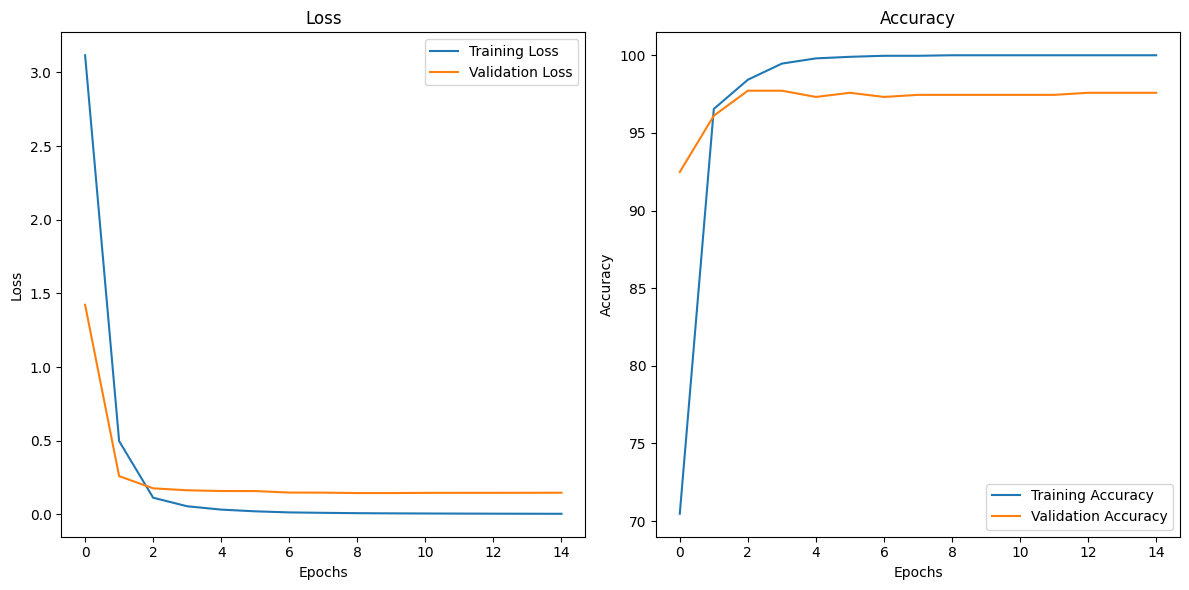

In [ ]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **TESTING**

In [ ]:
test_dir = "/content/drive/MyDrive/archive_birds_data/train"

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("Class names:", test_dataset.classes)

Class names: ['AMERICAN_GOLDFINCH', 'AMERICAN_PIPIT', 'AMERICAN_REDSTART', 'ANNAS_HUMMINGBIRD', 'BALTIMORE_ORIOLE', 'BARN_SWALLOW', 'BAY-BREASTED_WARBLER', 'BELTED_KINGFISHER', 'BLACK-THROATED_SPARROW', 'BLUE_GROSBEAK', 'BOBOLINK', 'BRANDT_CORMARANT', 'BREWERS_BLACKBIRD', 'BROWN_CREPPER', 'BROWN_THRASHER', 'CACTUS_WREN', 'CALIFORNIA_GULL', 'CAPE_GLOSSY_STARLING', 'CAPE_MAY_WARBLER', 'CASPIAN_TERN', 'CEDAR_WAXWING', 'CERULEAN_WARBLER', 'CHIPPING_SPARROW', 'CLARKS_NUTCRACKER', 'DARK_EYED_JUNCO', 'DOWNY_WOODPECKER', 'EASTERN_TOWEE', 'EUROPEAN_GOLDFINCH', 'EVENING_GROSBEAK', 'FRIGATE', 'GRAY_CATBIRD', 'GRAY_KINGBIRD', 'GREEN_JAY', 'HOODED_MERGANSER', 'HORNED_LARK', 'HOUSE_SPARROW', 'INDIGO_BUNTING', 'IVORY_GULL', 'LAZULI_BUNTING', 'LOGGERHEAD_SHRIKE', 'MALLARD_DUCK', 'MANGROVE_CUCKOO', 'NORTHERN_FLICKER', 'NORTHERN_FULMAR', 'NORTHERN_MOCKINGBIRD', 'OVENBIRD', 'PAINTED_BUNTING', 'PARAKETT__AKULET', 'POMARINE_JAEGER', 'PURPLE_FINCH', 'RED_FACED_CORMORANT', 'RED_HEADED_WOODPECKER', 'RED_WINGE

In [ ]:
training_class_names = train_data['class_name'].unique().tolist()

consistent_classes = {}

for test_id in test_dataset.classes:
    closest_match, _ = process.extractOne(test_id, training_class_names)
    consistent_classes[test_id] = closest_match
print(consistent_classes)

{'AMERICAN_GOLDFINCH': 'American_Goldfinch', 'AMERICAN_PIPIT': 'American_Pipit', 'AMERICAN_REDSTART': 'American_Redstart', 'ANNAS_HUMMINGBIRD': 'Anna_Hummingbird', 'BALTIMORE_ORIOLE': 'Baltimore_Oriole', 'BARN_SWALLOW': 'Barn_Swallow', 'BAY-BREASTED_WARBLER': 'Bay_breasted_Warbler', 'BELTED_KINGFISHER': 'Belted_Kingfisher', 'BLACK-THROATED_SPARROW': 'Black_throated_Sparrow', 'BLUE_GROSBEAK': 'Blue_Grosbeak', 'BOBOLINK': 'Bobolink', 'BRANDT_CORMARANT': 'Brandt_Cormorant', 'BREWERS_BLACKBIRD': 'Brewer_Blackbird', 'BROWN_CREPPER': 'Brown_Creeper', 'BROWN_THRASHER': 'Brown_Thrasher', 'CACTUS_WREN': 'Cactus_Wren', 'CALIFORNIA_GULL': 'California_Gull', 'CAPE_GLOSSY_STARLING': 'Cape_Glossy_Starling', 'CAPE_MAY_WARBLER': 'Cape_May_Warbler', 'CASPIAN_TERN': 'Caspian_Tern', 'CEDAR_WAXWING': 'Cedar_Waxwing', 'CERULEAN_WARBLER': 'Cerulean_Warbler', 'CHIPPING_SPARROW': 'Chipping_Sparrow', 'CLARKS_NUTCRACKER': 'Clark_Nutcracker', 'DARK_EYED_JUNCO': 'Dark_eyed_Junco', 'DOWNY_WOODPECKER': 'Downy_Woodp

In [ ]:
desired_class_to_idx = {
    'AMERICAN_GOLDFINCH': 21, 'AMERICAN_PIPIT': 43, 'AMERICAN_REDSTART': 45,
    'ANNAS_HUMMINGBIRD': 28, 'BALTIMORE_ORIOLE': 41, 'BARN_SWALLOW': 51,
    'BAY-BREASTED_WARBLER': 56, 'BELTED_KINGFISHER': 35, 'BLACK-THROATED_SPARROW': 47,
    'BLUE_GROSBEAK': 23, 'BOBOLINK': 4, 'BRANDT_CORMARANT': 12,
    'BREWERS_BLACKBIRD': 1, 'BROWN_CREPPER': 14, 'BROWN_THRASHER': 55,
    'CACTUS_WREN': 62, 'CALIFORNIA_GULL': 26, 'CAPE_GLOSSY_STARLING': 50,
    'CAPE_MAY_WARBLER': 57, 'CASPIAN_TERN': 54, 'CEDAR_WAXWING': 59,
    'CERULEAN_WARBLER': 58, 'CHIPPING_SPARROW': 48, 'CLARKS_NUTCRACKER': 40,
    'DARK_EYED_JUNCO': 32, 'DOWNY_WOODPECKER': 61, 'EASTERN_TOWEE': 11,
    'EUROPEAN_GOLDFINCH': 22, 'EVENING_GROSBEAK': 24, 'FRIGATE': 19,
    'GRAY_CATBIRD': 9, 'GRAY_KINGBIRD': 34, 'GREEN_JAY': 31,
    'HOODED_MERGANSER': 38, 'HORNED_LARK': 36, 'HOUSE_SPARROW': 49,
    'INDIGO_BUNTING': 5, 'IVORY_GULL': 27, 'LAZULI_BUNTING': 6,
    'LOGGERHEAD_SHRIKE': 46, 'MALLARD_DUCK': 37, 'MANGROVE_CUCKOO': 15,
    'NORTHERN_FLICKER': 17, 'NORTHERN_FULMAR': 20, 'NORTHERN_MOCKINGBIRD': 39,
    'OVENBIRD': 42, 'PAINTED_BUNTING': 7, 'PARAKETT__AKULET': 0,
    'POMARINE_JAEGER': 30, 'PURPLE_FINCH': 16, 'RED_FACED_CORMORANT': 13,
    'RED_HEADED_WOODPECKER': 60, 'RED_WINGED_BLACKBIRD': 2, 'ROSE_BREASTED_GROSBEAK': 25,
    'RUBY_THROATED_HUMMINGBIRD': 29, 'SCARLET_TANAGER': 53, 'SPOTTED_CATBIRD': 8,
    'TREE_SWALLOW': 52, 'TROPICAL_KINGBIRD': 33, 'VERMILION_FLYCATHER': 18,
    'WHITE_NECKED_RAVEN': 44, 'YELLOW_BREASTED_CHAT': 10, 'YELLOW_HEADED_BLACKBIRD': 3
}

class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform, target_transform=target_transform)
        original_classes = self.classes
        new_classes = [consistent_classes.get(cls, cls) for cls in original_classes]
        self.class_to_idx = {new_classes[i]: desired_class_to_idx[original_classes[i]] for i in range(len(original_classes))}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        self.samples = [(path, self.class_to_idx[new_classes[target]]) for path, target in self.samples]
        self.targets = [self.class_to_idx[new_classes[target]] for target in self.targets]
        self.classes = new_classes

test_dataset = CustomImageFolder(root=test_dir, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print("Class names:", test_dataset.classes)

Class names: ['American_Goldfinch', 'American_Pipit', 'American_Redstart', 'Anna_Hummingbird', 'Baltimore_Oriole', 'Barn_Swallow', 'Bay_breasted_Warbler', 'Belted_Kingfisher', 'Black_throated_Sparrow', 'Blue_Grosbeak', 'Bobolink', 'Brandt_Cormorant', 'Brewer_Blackbird', 'Brown_Creeper', 'Brown_Thrasher', 'Cactus_Wren', 'California_Gull', 'Cape_Glossy_Starling', 'Cape_May_Warbler', 'Caspian_Tern', 'Cedar_Waxwing', 'Cerulean_Warbler', 'Chipping_Sparrow', 'Clark_Nutcracker', 'Dark_eyed_Junco', 'Downy_Woodpecker', 'Eastern_Towhee', 'European_Goldfinch', 'Evening_Grosbeak', 'Frigatebird', 'Gray_Catbird', 'Gray_Kingbird', 'Green_Jay', 'Hooded_Merganser', 'Horned_Lark', 'House_Sparrow', 'Indigo_Bunting', 'Ivory_Gull', 'Lazuli_Bunting', 'Loggerhead_Shrike', 'Mallard', 'Mangrove_Cuckoo', 'Northern_Flicker', 'Northern_Fulmar', 'Mockingbird', 'Ovenbird', 'Painted_Bunting', 'Parakeet_Auklet', 'Pomarine_Jaeger', 'Purple_Finch', 'Red_faced_Cormorant', 'Red_headed_Woodpecker', 'Red_winged_Blackbird',

In [ ]:
model_path = "/content/best_model.pth"
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(test_dataset.classes))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

test_loss = 0
correct_test = 0
total_test = 0
all_labels = []
all_predictions = []

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for itr, (image, label) in tqdm(enumerate(test_loader), total=len(test_loader)):
        image, label = image.to(device), label.to(device)

        outputs = model(image).logits
        loss = criterion(outputs, label)
        test_loss += loss.item()

        predicted = torch.argmax(outputs, dim=1)
        all_labels.extend(label.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        total_test += label.size(0)
        correct_test += (predicted == label).sum().item()

accuracy_test = (100 * correct_test) / total_test
test_loss /= len(test_loader)

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
class_report = classification_report(all_labels, all_predictions, target_names=test_dataset.classes)

print(f'Test Loss: {test_loss:.8f}, Test Accuracy: {accuracy_test:.8f}')
print(f'Precision: {precision:.8f}')
print(f'Recall: {recall:.8f}')
print(f'F1 Score: {f1:.8f}')
print('\nClassification Report:\n', class_report)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 156/156 [02:00<00:00,  1.30it/s]

Test Loss: 0.14323088, Test Accuracy: 96.58076807
Precision: 0.96811155
Recall: 0.96580768
F1 Score: 0.96595461

Classification Report:
                            precision    recall  f1-score   support

       American_Goldfinch       1.00      1.00      1.00       155
           American_Pipit       0.96      0.90      0.93       183
        American_Redstart       0.99      0.86      0.92       152
         Anna_Hummingbird       0.96      0.98      0.97       159
         Baltimore_Oriole       1.00      0.94      0.97       157
             Barn_Swallow       0.90      0.92      0.91       153
     Bay_breasted_Warbler       0.96      0.98      0.97       157
        Belted_Kingfisher       1.00      0.99      1.00       163
   Black_throated_Sparrow       0.95      0.96      0.96       150
            Blue_Grosbeak       0.94      0.99      0.97       155
                 Bobolink       0.99      1.00      0.99       202
         Brandt_Cormorant       1.00      0.99      1.00  


# **Interpretation of Test Results**
The model demonstrates exceptional performance on the test dataset, achieving a high accuracy of 96.58%. This indicates that it correctly predicted the class labels for the vast majority of the samples. Additionally, the test loss is notably low at 0.1432, which reflects that the model's predictions are very close to the actual labels, signifying effective minimization of error.

Overall, these results suggest that the model is performing excellently and is well-suited for the task at hand.

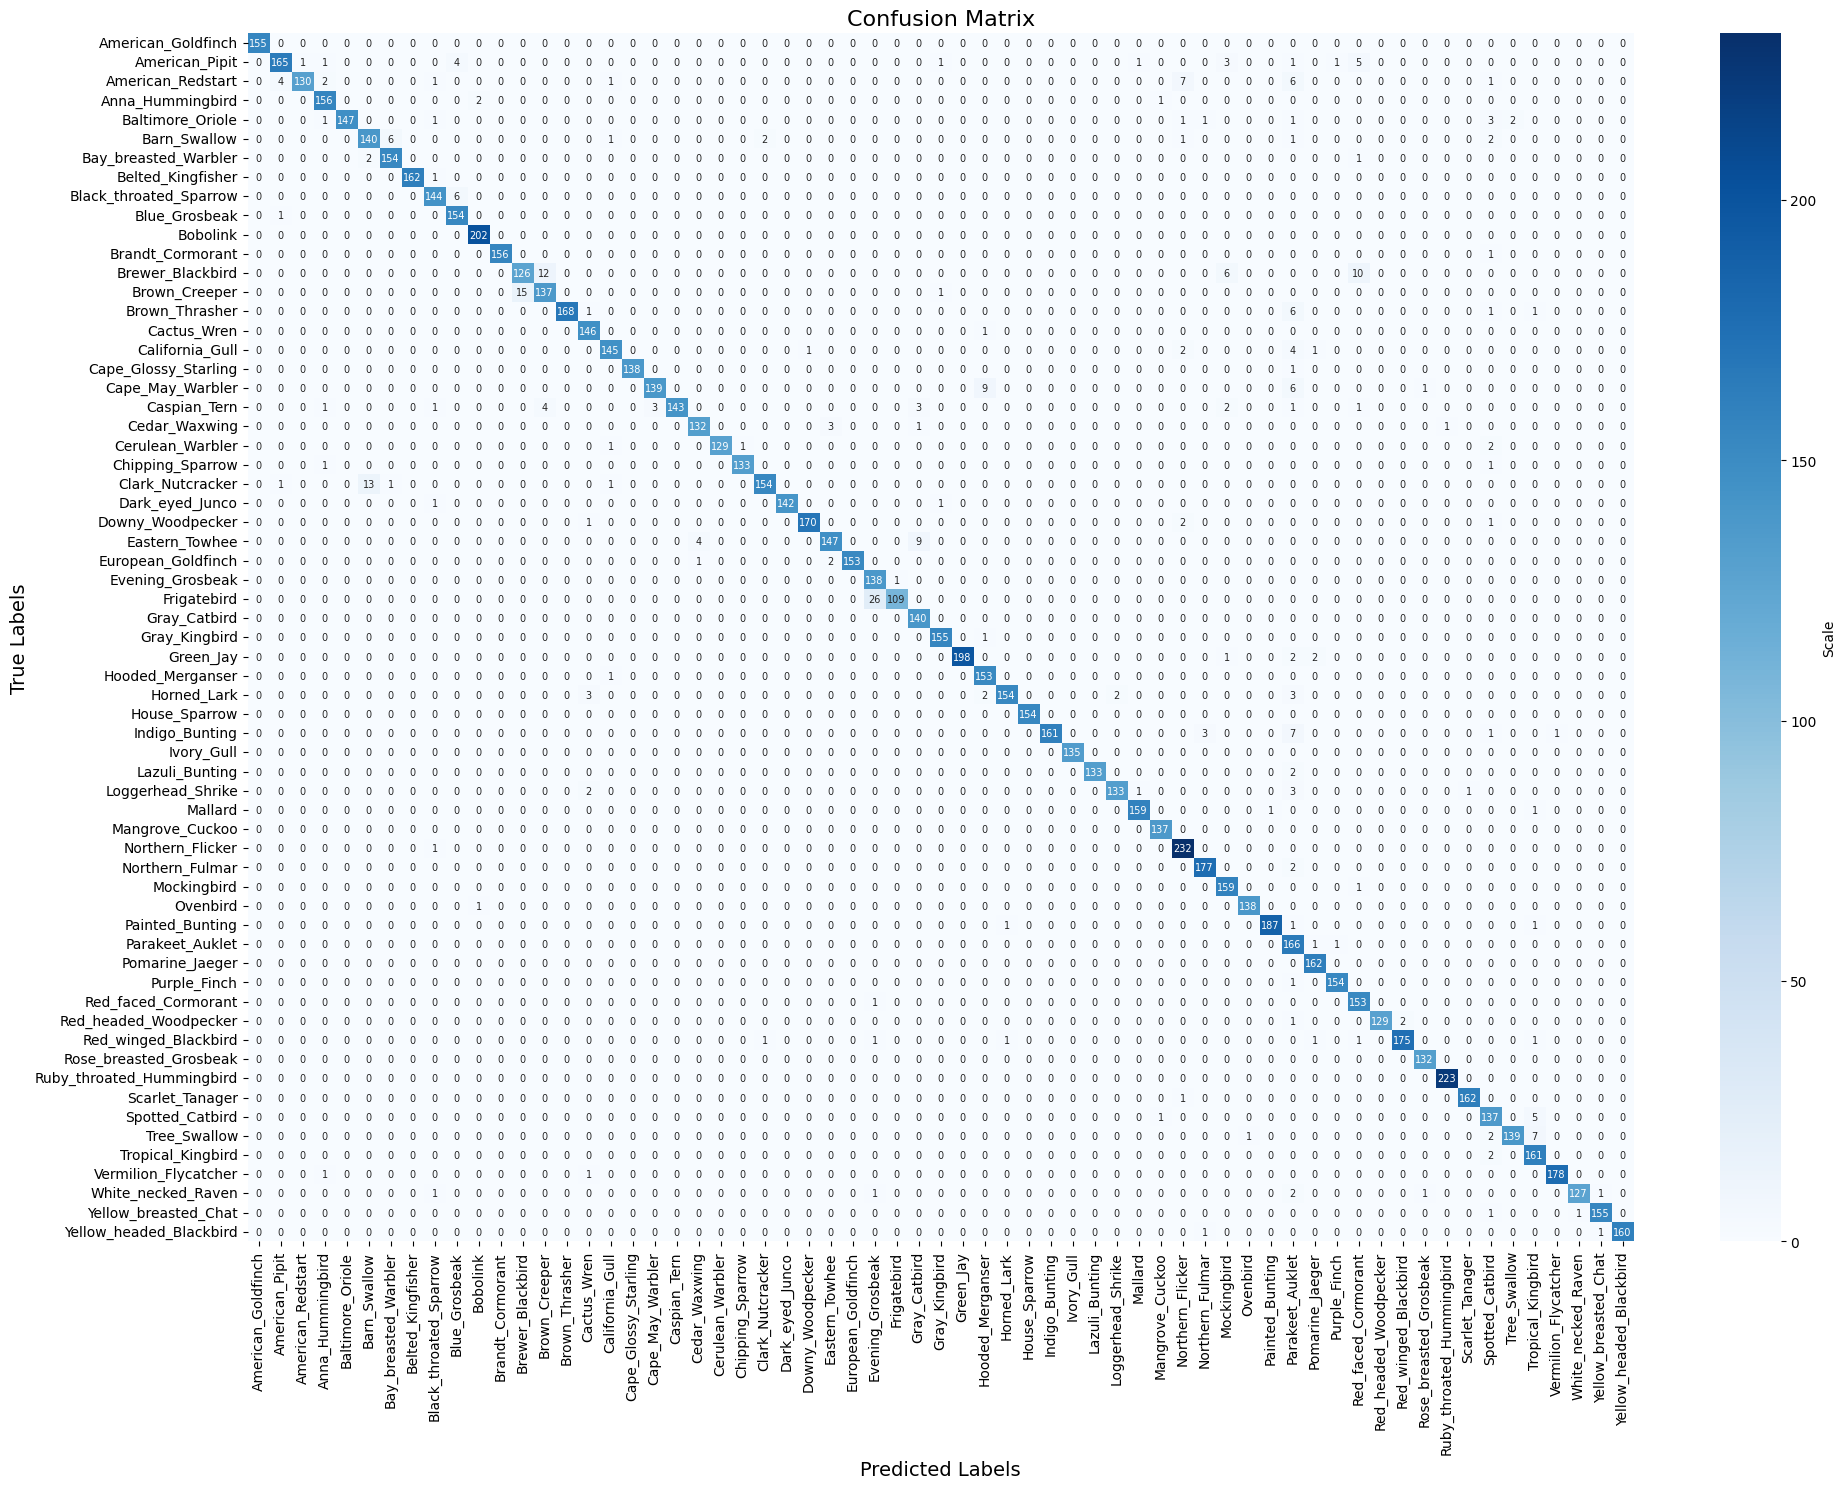

In [ ]:

conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(20, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes,
            cbar_kws={'label': 'Scale'}, annot_kws={'size': 7})
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# **Enhanced Confusion Matrix Code with Normalization:**

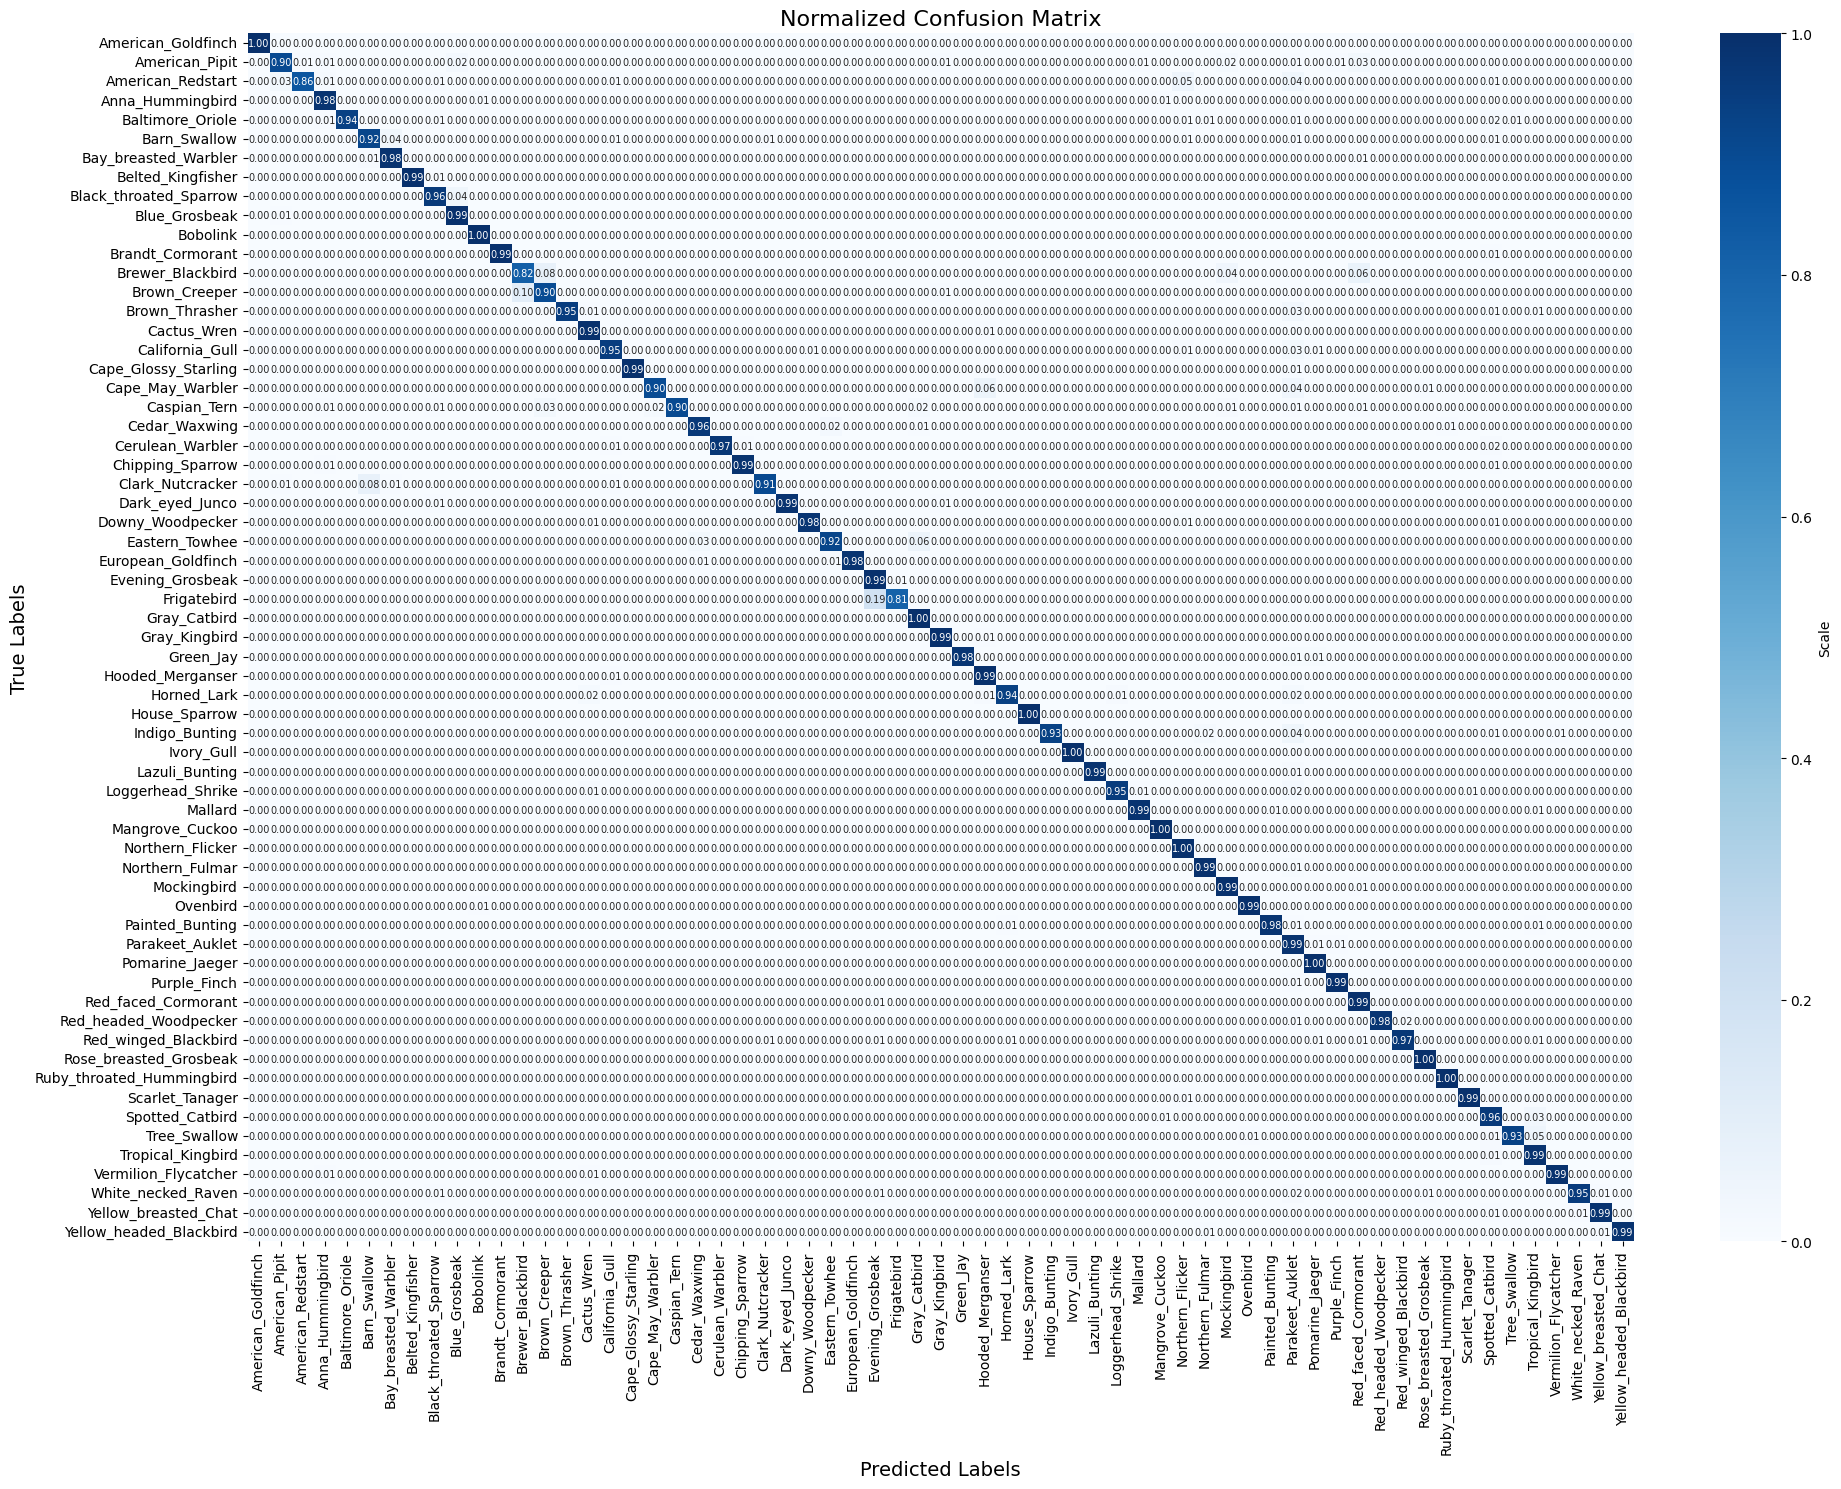

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 15))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes,
            cbar_kws={'label': 'Scale'}, annot_kws={'size': 7})
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()